# Dense Embeddings with Open Source Models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import uuid
import pandas as pd
from datasets import load_dataset
from fastembed import TextEmbedding  # vs sentecetransformers
from qdrant_client import models, QdrantClient
import tiktoken

from src import utils


c:\Users\manuelalberto.romero\Documents\repos\dslabs\mbit\peia-oct25\dslab-rag-retrieval\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Params

In [ ]:
INDEX = "ragquas-minilm-01"  # qdrant collection
MODEL_ID = "BAAI/bge-small-en-v1.5"	
RETRIEVE_K=5
EVAL_K = 3

In [4]:
# encoding = tiktoken.get_encoding("cl100k_base")
encoding = tiktoken.encoding_for_model("gpt-4o")

# Load Data

In [5]:
ds_ragquas = load_dataset("IIC/RagQuAS")  # HF Dataset
ds_ragquas
# https://huggingface.co/datasets/IIC/RagQuAS

DatasetDict({
    test: Dataset({
        features: ['topic', 'answer', 'question', 'variant', 'context_1', 'context_2', 'context_3', 'context_4', 'context_5', 'link_1', 'link_2', 'link_3', 'link_4', 'link_5', 'text_1', 'text_2', 'text_3', 'text_4', 'text_5'],
        num_rows: 201
    })
})

In [6]:
ds_ragquas["test"].take(2).to_pandas()

,topic,answer,question,variant,context_1,context_2,context_3,context_4,context_5,link_1,link_2,link_3,link_4,link_5,text_1,text_2,text_3,text_4,text_5
0,reclamaciones,La opción más fácil y eficaz para reclamar una...,¿Cuál es la forma más fácil de reclamar cuando...,question_1,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,En AirHelp hemos ayudado a más de 16 millones ...,"MYFLYRIGHT, expertos en derechos de los viajer...",,,https://www.businessinsider.es/mejores-paginas...,https://www.airhelp.com/es/retrasos-de-vuelos/,https://myflyright.com/es/servicios/vuelo-retr...,,,5 páginas donde poder reclamar tus vuelos por ...,Conoce las compensaciones cuando se retrasa tu...,Indemnización retraso vuelo\n\nNavegación por ...,,
1,reclamaciones,La opción más fácil y eficaz para reclamar una...,hola mi vuelo a Alemania se ha retrasado mucho...,question_2,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,En AirHelp hemos ayudado a más de 16 millones ...,"MYFLYRIGHT, expertos en derechos de los viajer...",,,https://www.businessinsider.es/mejores-paginas...,https://www.airhelp.com/es/retrasos-de-vuelos/,https://myflyright.com/es/servicios/vuelo-retr...,,,5 páginas donde poder reclamar tus vuelos por ...,Conoce las compensaciones cuando se retrasa tu...,Indemnización retraso vuelo\n\nNavegación por ...,,


# Explore Data

In [7]:
df_ragquas = ds_ragquas["test"].to_pandas()

## Metadata

<Axes: title={'center': 'Topic Frequency'}, ylabel='topic'>

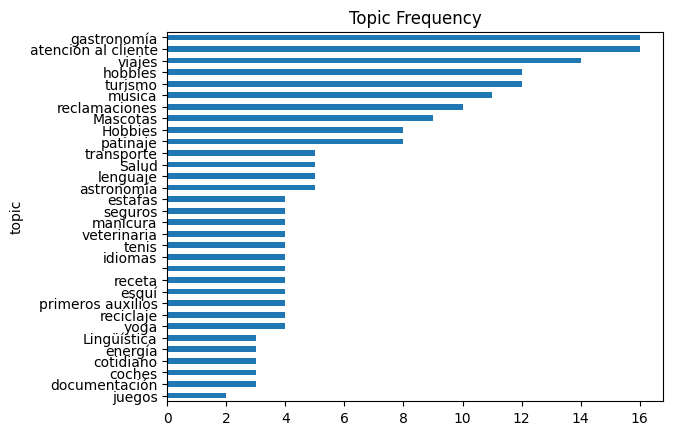

In [8]:
df_ragquas["topic"].value_counts().sort_values(ascending=True).plot.barh(
    title="Topic Frequency"
)

## Dataset Structure

In [9]:
df_ragquas["answer"].iloc[0]

'La opción más fácil y eficaz para reclamar una indemnización por retraso de vuelo en Europa es utilizar los servicios de compañías especializadas en reclamaciones de derechos de pasajeros. Estas compañías ofrecen un proceso simplificado y asistencia profesional, eliminando la necesidad de que el pasajero se involucre en trámites complicados y negociaciones con las aerolíneas. Aquí te presento algunas opciones recomendadas:\n\n    AirHelp: Esta empresa ha ayudado a más de 16 millones de pasajeros y opera en 30 países. Ofrecen un proceso sencillo donde solo necesitas introducir los detalles de tu vuelo en su calculadora online para comprobar si tienes derecho a compensación. Si es así, gestionarán todo el proceso de reclamación, incluyendo negociaciones con las aerolíneas, y te enviarán la compensación directamente. Solo cobran una comisión si la reclamación es exitosa\u200b\u200b.\n\nReclamador: Es una página española con una interfaz intuitiva y fácil de usar. Solo necesitas introduci

In [10]:
ans_rep = df_ragquas["answer"].value_counts()

ans_rep.iloc[0]  # se repite N veces, que son diferenciadas por variant (question, presenta pequeñas variaciones)

5

In [11]:
set(ans_rep.values)  # posibilidades de repetición de una respuesta

{2, 3, 4, 5}

In [12]:
df_variant_freq = df_ragquas["variant"].value_counts()
df_variant_freq


variant
question_1    50
question_2    50
question_3    49
question_4    41
question_5    11
Name: count, dtype: int64

In [14]:
df_answer_freq = df_ragquas["answer"].value_counts()  # primery key
df_answer_freq.values

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 2], dtype=int64)

In [15]:
len(df_answer_freq)  # number of different answers

50

In [13]:
df_ragquas[["context_1", "context_2", "context_3", "context_4",	"context_5"]].isna().sum()
# NANs como string vacio

context_1    0
context_2    0
context_3    0
context_4    0
context_5    0
dtype: int64

In [17]:
df_ragquas[["context_1", "context_2", "context_3", "context_4",	"context_5"]].apply(len).describe()
# cada celda tiene espacios vacios a la derecha

count      5.0
mean     201.0
std        0.0
min      201.0
25%      201.0
50%      201.0
75%      201.0
max      201.0
dtype: float64

# Prepare Data

In [18]:
# Como las columnas text_ están a lo ancho,
# hay que pivotarlas para colocaras a lo largo y codificar cada valor
# pero antes, como hay respuestas que hacen referencia al mismo texto fuente
# hay que quedarse solo con uno de los valores de variant

df_docs = pd.wide_to_long(
    (df_ragquas
     .reset_index()  # crea columna index
     .loc[df_ragquas['variant'] == "question_1"]
     ),
    stubnames=["context_", "text_", "link_"],  # columas a pivotar, solo prefijo
    i=["index", "topic", "variant", "question", "answer"],  # index en el df resultante
    j="j",  # numerador de _1 a _5  (numero de sufijos),
    suffix="\d+"  # forma del sufijo: numero
)


print(f"Raw shape: {df_docs.shape}")

# Como hay text con "", hay que eliminarlos para no indexar algo vacio
df_docs["text_"] = (df_docs["text_"]
           .apply(str.rstrip)
           .replace({"": pd.NA})
           )

df_docs = (df_docs
           .dropna()
           .reset_index()
           )

# agregar un id a cada text_ para poder hacer la evaluacion posteiormente
df_docs['uuid'] = [str(uuid.uuid4()) for _ in range(len(df_docs))]


df_docs.info()

Raw shape: (250, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     183 non-null    int64 
 1   topic     183 non-null    object
 2   variant   183 non-null    object
 3   question  183 non-null    object
 4   answer    183 non-null    object
 5   j         183 non-null    int64 
 6   context_  183 non-null    object
 7   text_     183 non-null    object
 8   link_     183 non-null    object
 9   uuid      183 non-null    object
dtypes: int64(2), object(8)
memory usage: 14.4+ KB


<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
C:\Users\manuelalberto.romero\AppData\Local\Temp\ipykernel_28352\3837530465.py:14: SyntaxWarning: invalid escape sequence '\d'
  suffix="\d+"  # forma del sufijo: numero


In [22]:
df_ragquas.head(7)

,topic,answer,question,variant,context_1,context_2,context_3,context_4,context_5,link_1,link_2,link_3,link_4,link_5,text_1,text_2,text_3,text_4,text_5
0,reclamaciones,La opción más fácil y eficaz para reclamar una...,¿Cuál es la forma más fácil de reclamar cuando...,question_1,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,En AirHelp hemos ayudado a más de 16 millones ...,"MYFLYRIGHT, expertos en derechos de los viajer...",,,https://www.businessinsider.es/mejores-paginas...,https://www.airhelp.com/es/retrasos-de-vuelos/,https://myflyright.com/es/servicios/vuelo-retr...,,,5 páginas donde poder reclamar tus vuelos por ...,Conoce las compensaciones cuando se retrasa tu...,Indemnización retraso vuelo\n\nNavegación por ...,,
1,reclamaciones,La opción más fácil y eficaz para reclamar una...,hola mi vuelo a Alemania se ha retrasado mucho...,question_2,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,En AirHelp hemos ayudado a más de 16 millones ...,"MYFLYRIGHT, expertos en derechos de los viajer...",,,https://www.businessinsider.es/mejores-paginas...,https://www.airhelp.com/es/retrasos-de-vuelos/,https://myflyright.com/es/servicios/vuelo-retr...,,,5 páginas donde poder reclamar tus vuelos por ...,Conoce las compensaciones cuando se retrasa tu...,Indemnización retraso vuelo\n\nNavegación por ...,,
2,reclamaciones,La opción más fácil y eficaz para reclamar una...,cómo puedo poner una reclamación para que me d...,question_3,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,En AirHelp hemos ayudado a más de 16 millones ...,"MYFLYRIGHT, expertos en derechos de los viajer...",,,https://www.businessinsider.es/mejores-paginas...,https://www.airhelp.com/es/retrasos-de-vuelos/,https://myflyright.com/es/servicios/vuelo-retr...,,,5 páginas donde poder reclamar tus vuelos por ...,Conoce las compensaciones cuando se retrasa tu...,Indemnización retraso vuelo\n\nNavegación por ...,,
3,reclamaciones,La opción más fácil y eficaz para reclamar una...,forma eficaz de reclamar a aerolinea por retra...,question_4,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,En AirHelp hemos ayudado a más de 16 millones ...,"MYFLYRIGHT, expertos en derechos de los viajer...",,,https://www.businessinsider.es/mejores-paginas...,https://www.airhelp.com/es/retrasos-de-vuelos/,https://myflyright.com/es/servicios/vuelo-retr...,,,5 páginas donde poder reclamar tus vuelos por ...,Conoce las compensaciones cuando se retrasa tu...,Indemnización retraso vuelo\n\nNavegación por ...,,
4,reclamaciones,La opción más fácil y eficaz para reclamar una...,hay alguna forma de reclamar por retrasos en v...,question_5,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,En AirHelp hemos ayudado a más de 16 millones ...,"MYFLYRIGHT, expertos en derechos de los viajer...",,,https://www.businessinsider.es/mejores-paginas...,https://www.airhelp.com/es/retrasos-de-vuelos/,https://myflyright.com/es/servicios/vuelo-retr...,,,5 páginas donde poder reclamar tus vuelos por ...,Conoce las compensaciones cuando se retrasa tu...,Indemnización retraso vuelo\n\nNavegación por ...,,
5,hobbies,Si estás interesado en buscar setas en la Sier...,Quiero ir a buscar setas por la Sierra de Madr...,question_1,1. Siempre hay que respetar el entorno natural...,No recolectar ni aceptar setas que no conozcam...,Las setas se recogen en cestas y nunca en bols...,Setas en Alameda del valle.\n\nEste pequeño ri...,Valle del Paular\n\nConocido también con el no...,https://www.sierranorte.com/consejos-coger-set...,https://www.comunidad.madrid/servicios/salud/s...,https://madridsecreto.co/buscar-setas-madrid/#...,https://lacasadelassetas.com/blog/buscar-setas...,https://www.larazon.es/madrid/mejores-lugares-...,10 Consejos Básicos para coger Setas en la Sie...,Recoger y consumir setas silvestres\n\nLa iden...,Los mejores lugares para buscar setas en la Co...,Escaparse de Madrid para buscar setas\nBuscar ...,Los mejores lugares para buscar setas en Madri...
6,hobbies,Si estás interesado en buscar setas en la Sier...,"hola, v

In [20]:
df_docs.iloc[:6]

,index,topic,variant,question,answer,j,context_,text_,link_,uuid
0,0,reclamaciones,question_1,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,1,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,5 páginas donde poder reclamar tus vuelos por ...,https://www.businessinsider.es/mejores-paginas...,7e0a0145-1178-4ea5-81a7-146fa7bfc3ee
1,0,reclamaciones,question_1,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,2,En AirHelp hemos ayudado a más de 16 millones ...,Conoce las compensaciones cuando se retrasa tu...,https://www.airhelp.com/es/retrasos-de-vuelos/,12855dca-d064-490b-9175-1b56a28577c5
2,0,reclamaciones,question_1,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,3,"MYFLYRIGHT, expertos en derechos de los viajer...",Indemnización retraso vuelo\n\nNavegación por ...,https://myflyright.com/es/servicios/vuelo-retr...,1f9acd24-e0a9-4421-abfa-125615c0e5af
3,5,hobbies,question_1,Quiero ir a buscar setas por la Sierra de Madr...,Si estás interesado en buscar setas en la Sier...,1,1. Siempre hay que respetar el entorno natural...,10 Consejos Básicos para coger Setas en la Sie...,https://www.sierranorte.com/consejos-coger-set...,3dfecc77-a5ef-40d0-b654-30e2464194ba
4,5,hobbies,question_1,Quiero ir a buscar setas por la Sierra de Madr...,Si estás interesado en buscar setas en la Sier...,2,No recolectar ni aceptar setas que no conozcam...,Recoger y consumir setas silvestres\n\nLa iden...,https://www.comunidad.madrid/servicios/salud/s...,5d547b59-e47e-4ed6-b91c-740cc1d85a7e
5,5,hobbies,question_1,Quiero ir a buscar setas por la Sierra de Madr...,Si estás interesado en buscar setas en la Sier...,3,Las setas se recogen en cestas y nunca en bols...,Los mejores lugares para buscar setas en la Co...,https://madridsecreto.co/buscar-setas-madrid/#...,85658bce-1866-4484-a0e9-45d20673229e


## Document Length

In [23]:
corpus_lens = utils.corpus_stats(encoding, df_docs['text_'])
corpus_stats = corpus_lens.describe()
corpus_stats

count     183.000000
mean     1780.010929
std      1455.906738
min       149.000000
25%       841.500000
50%      1275.000000
75%      2248.000000
max      7347.000000
dtype: float64

# Encode

In [25]:
encoder = TextEmbedding(MODEL_ID)  # FastEmbed

lst_embeddings = list(encoder.embed(df_docs['text_'].tolist()))
# los texts_ que superen la longitud de contexto de `MODEL_ID` se han truncado


print(f"{len(lst_embeddings)}")  # n rows -> texts
print(f"{len(lst_embeddings[0])}")  # embeddings dimension

183
384


# Dense Search in Qdrant

Qdrant acepta como entrada una estructura de datos denominada Point que tiene esta forma:

```python
{
    "id": 129,
    "vector": [0.1, 0.2, 0.3, 0.4],
    "payload": {"color": "red"},
}
```

[Points](https://qdrant.tech/documentation/concepts/points/)

# Index

In [26]:
df_docs['text_']

0      5 páginas donde poder reclamar tus vuelos por ...
1      Conoce las compensaciones cuando se retrasa tu...
2      Indemnización retraso vuelo\n\nNavegación por ...
3      10 Consejos Básicos para coger Setas en la Sie...
4      Recoger y consumir setas silvestres\n\nLa iden...
                             ...                        
178    Colorless green ideas sleep furiously\n\n    A...
179    Colorless green ideas sleep furiously\n\n    A...
180    TELÉFONO GRATUITO OBJETOS PERDIDOS DE LA EMT\n...
181    Atención Al Cliente Objetos Perdidos de la EMT...
182    Oficina de objetos perdidos de la Empresa Muni...
Name: text_, Length: 183, dtype: object

In [ ]:
# src.embeddings. create_index_points() + create_index_points()
lst_qdrant_pts = []

for idx, row in df_docs.iterrows():
    qdrant_point = models.PointStruct(
        id=row['uuid'],  # uuid aleatorio
        payload={
            "text": row['text_'],
            "topic": row['topic'],
            "answer_idx": row['index'],  # index antes de filtrar las variant == question1
            "text_j": row['j'],
            "idx":  row['index'],  
        },
        vector=lst_embeddings[idx]  # se puede buscar directamente en la lista por indice del DF pivotado
    )
    lst_qdrant_pts.append(qdrant_point)

len(lst_qdrant_pts) == len(df_docs)  # comprobar

In [28]:
encoder.embedding_size

384

In [29]:
INDEX

'ragquas-minilm-01'

In [30]:
# Instanciate client
# Si está levantada localmente: QdrantClient("http://localhost:6333")
# SI se usa la versión cloud, introducir la url

client = QdrantClient(":memory:")  # en memoria

client.create_collection(
    collection_name=INDEX,
    vectors_config=models.VectorParams(
        size=encoder.embedding_size,
        distance=models.Distance.COSINE,
    ),
)

client.upsert(
    collection_name=INDEX,
    points=lst_qdrant_pts
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [31]:
df_docs

,index,topic,variant,question,answer,j,context_,text_,link_,uuid
0,0,reclamaciones,question_1,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,1,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,5 páginas donde poder reclamar tus vuelos por ...,https://www.businessinsider.es/mejores-paginas...,7e0a0145-1178-4ea5-81a7-146fa7bfc3ee
1,0,reclamaciones,question_1,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,2,En AirHelp hemos ayudado a más de 16 millones ...,Conoce las compensaciones cuando se retrasa tu...,https://www.airhelp.com/es/retrasos-de-vuelos/,12855dca-d064-490b-9175-1b56a28577c5
2,0,reclamaciones,question_1,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,3,"MYFLYRIGHT, expertos en derechos de los viajer...",Indemnización retraso vuelo\n\nNavegación por ...,https://myflyright.com/es/servicios/vuelo-retr...,1f9acd24-e0a9-4421-abfa-125615c0e5af
3,5,hobbies,question_1,Quiero ir a buscar setas por la Sierra de Madr...,Si estás interesado en buscar setas en la Sier...,1,1. Siempre hay que respetar el entorno natural...,10 Consejos Básicos para coger Setas en la Sie...,https://www.sierranorte.com/consejos-coger-set...,3dfecc77-a5ef-40d0-b654-30e2464194ba
4,5,hobbies,question_1,Quiero ir a buscar setas por la Sierra de Madr...,Si estás interesado en buscar setas en la Sier...,2,No recolectar ni aceptar setas que no conozcam...,Recoger y consumir setas silvestres\n\nLa iden...,https://www.comunidad.madrid/servicios/salud/s...,5d547b59-e47e-4ed6-b91c-740cc1d85a7e
...,...,...,...,...,...,...,...,...,...,...
178,194,Lingüística,question_1,"Buenas tardes, ¿podría explicarme el significa...",La oración Colorless green ideas sleep furious...,1,«Colorless green ideas sleep furiously» (en es...,Colorless green ideas sleep furiously\n\n A...,https://es.wikipedia.org/wiki/Colorless_green_...,f72f8acc-5ead-47f5-af0a-7d19f10f4301
179,194,Lingüística,question_1,"Buenas tardes, ¿podría explicarme el significa...",La oración Colorless green ideas sleep furious...,2,Aunque la oración sea gramaticalmente correcta...,Colorless green ideas sleep furiously\n\n A...,https://es.wikipedia.org/wiki/Colorless_green_...,70f118f4-73ce-4028-91cf-395473638e71
180,197,atención al cliente,question_1,me he dejado olvidado mi bufanda en el autobús...,Para recuperar tu bufanda olvidada en un autob...,1,¿Puedo llamar al teléfono de Objetos Perdidos ...,TELÉFONO GRATUITO OBJETOS PERDIDOS DE LA EMT\n...,https://www.telefonogratuito.com/objetos-perdi...,7d0805cc-c233-43ca-9e68-5172b9c9a593
181,197,atención al cliente,question_1,me he dejado olvidado mi bufanda en el autobús...,Para recuperar tu bufanda olvidada en un autob...,2,Contactar con Objetos Perdidos de la EMT por C...,Atención Al Cliente Objetos Perdidos de la EMT...,https://atencioncliente.com/objetos-perdidos-d...,c0184a54-8b49-4f27-9d89-17a45592ff1c


In [ ]:
# 7e0a0145-1178-4ea5-81a7-146fa7bfc3ee

In [32]:
# query by id
_id = lst_qdrant_pts[0].id
print(f"{_id=}")

client.retrieve(
    collection_name=INDEX,
    ids=[_id]
)



_id='7e0a0145-1178-4ea5-81a7-146fa7bfc3ee'


[Record(id='7e0a0145-1178-4ea5-81a7-146fa7bfc3ee', payload={'text': '5 páginas donde poder reclamar tus vuelos por retraso o cancelación de manera gratuita\nIrina Pérez\n\n    En muchas ocasiones no se realiza la reclamación de un vuelo por retraso o cancelación, porque se desconocen los derechos como pasajeros y la manera de realizar el trámite. \n    Por ello, aquí van 5 reclamadores online que te ayudarán a conseguir una indemnización por tu vuelo, sin que tengas que desplazarte ni hacer papeleos.\n    Descubre más historias en Business Insider España.\n\nVolar es siempre sinónimo de nervios, normalmente ir al aeropuerto con tiempo, las colas en facturación, o cualquier imprevisto, hacen que a veces viajar sea una odisea. En el peor de los casos tu vuelo puede sufrir retrasos e incluso cancelarse. Pero, ¿sabías que tienes derecho a una compensación económica cuando esto ocurre?\n\nEn muchas ocasiones reclamar, es algo que se deja pasar porque es tedioso, y requiere hacer papeleo, de

# Query

In [34]:
# query by vector (retrieval)

_q_text = df_docs.iloc[0]["question"]
_q = next(encoder.embed(_q_text))

resp = client.query_points(
    collection_name=INDEX,
    query=_q,  # vectorizada
    limit=10  # K 
)

# idx: row in dataset
# j: position in text_columns (relevancy)
print(f"Question: {_q_text}")
for point in resp.points:
    doc_retrieved = point.payload['text']
    print(f"{point.id=}")
    print(f"{point.score=}")
    print(f"Doc: {doc_retrieved[:500]}...")
    print(f"idx: {point.payload['idx']}, j: {point.payload['text_j']}")
    print("-"*30)

Question: ¿Cuál es la forma más fácil de reclamar cuando un vuelo que sale de España se ha retrasado?
point.id='12855dca-d064-490b-9175-1b56a28577c5'
point.score=0.793186305358361
Doc: Conoce las compensaciones cuando se retrasa tu vuelo

Llegas al aeropuerto y tu vuelo va con retraso, ¿conoces cuáles son tus derechos y si puedes pedir reclamar una compensación? Desde AirHelp te ayudamos con los trámites para que tu viaje no se convierta en una pesadilla y puedas conocer todos los casos en los que puedes hacer una reclamación y el plazo para realizar los reclamos. ¡Te ayudaremos a reclamar tu indemnización por si tu vuelo se retrasa!

Desplazarse en avión es para muchas person...
idx: 0, j: 2
------------------------------
point.id='7e0a0145-1178-4ea5-81a7-146fa7bfc3ee'
point.score=0.7765942975418634
Doc: 5 páginas donde poder reclamar tus vuelos por retraso o cancelación de manera gratuita
Irina Pérez

    En muchas ocasiones no se realiza la reclamación de un vuelo por retraso o canc

In [35]:
# check retrieval scores

se_scores = pd.Series(data=[point.score for point in resp.points])
se_scores.index.name = "rank"
se_scores.name = "scores"
se_scores

rank
0    0.793186
1    0.776594
2    0.733050
3    0.729829
4    0.710141
5    0.688409
6    0.671880
7    0.666410
8    0.666410
9    0.665184
Name: scores, dtype: float64

# Evaluation

**Discounted Cumulative Gain**
$$DCG@k = \sum_{i=1}^{k} \frac{2^{rel_i} - 1}{\log_2(i+1)}$$

**Ideal Discounted Cumulative Gain**

$$IDCG@k = \sum_{i=1}^{k} \frac{2^{rel_i^\ast} - 1}{\log_2(i+1)}$$

**Normalized DCG**
$$NDCG@k = \frac{DCG@k}{IDCG@k}$$

[sklearn ndcg_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html)

## Get y_trues


In [41]:
df_ytrues = (df_docs[["index", "question", "answer", "j", "text_", "uuid"]]
             .rename(columns={"j": "y_true"})
             )
df_ytrues.head()

,index,question,answer,y_true,text_,uuid
0,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,1,5 páginas donde poder reclamar tus vuelos por ...,7e0a0145-1178-4ea5-81a7-146fa7bfc3ee
1,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,2,Conoce las compensaciones cuando se retrasa tu...,12855dca-d064-490b-9175-1b56a28577c5
2,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,3,Indemnización retraso vuelo\n\nNavegación por ...,1f9acd24-e0a9-4421-abfa-125615c0e5af
3,5,Quiero ir a buscar setas por la Sierra de Madr...,Si estás interesado en buscar setas en la Sier...,1,10 Consejos Básicos para coger Setas en la Sie...,3dfecc77-a5ef-40d0-b654-30e2464194ba
4,5,Quiero ir a buscar setas por la Sierra de Madr...,Si estás interesado en buscar setas en la Sier...,2,Recoger y consumir setas silvestres\n\nLa iden...,5d547b59-e47e-4ed6-b91c-740cc1d85a7e


## Get y_preds

In [36]:
lst_retrivals = []
df_ans = df_docs.loc[df_docs['j'] == 1, ["index", "question"]]  # questions are repeated

for idx, row in df_ans.iterrows():
    _q_text = row["question"]  # cada question del dataset
    _q = next(encoder.embed(_q_text))  # vector
    _resp = client.query_points(  # retrieve k
        collection_name=INDEX,
        query=_q,
        limit=RETRIEVE_K
    )
    for rank, point in enumerate(_resp.points):
        lst_retrivals.append(
            {
                "index": row["index"],
                "uuid": point.id,
                "y_pred": rank +1

            }
        )

df_yhats =  pd.DataFrame(lst_retrivals)
df_yhats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   250 non-null    int64 
 1   uuid    250 non-null    object
 2   y_pred  250 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 6.0+ KB


In [38]:
df_yhats.head(5)

,index,uuid,y_pred
0,0,12855dca-d064-490b-9175-1b56a28577c5,1
1,0,7e0a0145-1178-4ea5-81a7-146fa7bfc3ee,2
2,0,1f9acd24-e0a9-4421-abfa-125615c0e5af,3
3,0,29c99e19-7420-4652-8617-9e8bff300a57,4
4,0,14a9f216-31e7-4ee3-8d5a-17b19786a31c,5


## Format the Dataset 

* Each row is a question
* `y_true` a list where each element represent a given document (`uuid`) actual rank
* `y_pred` a list where each element represent the same document on `y_true` predicted rank
* Both list must have the same number of elements `EVAL_K`

| index | y_true     | y_pred     |
|-------|------------|------------|
| 0     | [1, 2, 3]  | [2, 3, 5]  |
| 5     | [3, 4, 5]  | [2, 1, 3]  |
| 12    | [1, 2, 3]  | [2, 5, 4]  |


In [42]:
df_ytrues.head(2)

,index,question,answer,y_true,text_,uuid
0,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,1,5 páginas donde poder reclamar tus vuelos por ...,7e0a0145-1178-4ea5-81a7-146fa7bfc3ee
1,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,2,Conoce las compensaciones cuando se retrasa tu...,12855dca-d064-490b-9175-1b56a28577c5


In [43]:
df_yhats.head(2)

,index,uuid,y_pred
0,0,12855dca-d064-490b-9175-1b56a28577c5,1
1,0,7e0a0145-1178-4ea5-81a7-146fa7bfc3ee,2


In [44]:
df_eval = df_ytrues.merge(df_yhats, how="left", on=['index', 'uuid'])  # los elementos de las listas deben ser los mismos documentos
df_eval.head(5)


,index,question,answer,y_true,text_,uuid,y_pred
0,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,1,5 páginas donde poder reclamar tus vuelos por ...,7e0a0145-1178-4ea5-81a7-146fa7bfc3ee,2.0
1,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,2,Conoce las compensaciones cuando se retrasa tu...,12855dca-d064-490b-9175-1b56a28577c5,1.0
2,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,3,Indemnización retraso vuelo\n\nNavegación por ...,1f9acd24-e0a9-4421-abfa-125615c0e5af,3.0
3,5,Quiero ir a buscar setas por la Sierra de Madr...,Si estás interesado en buscar setas en la Sier...,1,10 Consejos Básicos para coger Setas en la Sie...,3dfecc77-a5ef-40d0-b654-30e2464194ba,4.0
4,5,Quiero ir a buscar setas por la Sierra de Madr...,Si estás interesado en buscar setas en la Sier...,2,Recoger y consumir setas silvestres\n\nLa iden...,5d547b59-e47e-4ed6-b91c-740cc1d85a7e,NaN


In [45]:
pd.crosstab(
    df_eval["y_true"],
    df_eval["y_pred"],
    dropna=False  # no recuperado

)

y_pred,1.0,2.0,3.0,4.0,5.0,NaN
y_true,,,,,,
1,11,10,9,9,5,6
2,15,14,5,5,1,9
3,8,11,11,4,1,7
4,8,4,6,3,3,3
5,2,3,3,3,2,2


In [46]:
import numpy as np
from sklearn.metrics import ndcg_score

df_eval_ndcg = df_eval[["uuid", "index", "y_true", "y_pred"]].fillna(99)   # si no se recupera, se le da un número muy grande
df_eval_ndcg['y_pred'] = df_eval_ndcg['y_pred'].astype(int)  # casteado a float por los nan

# Colapsar todas las y_trues e y_pred de una question en una sola fila,
# de tal forma que las celdas sean listas, pero del un tamaño `EVAL_K`
df_eval_ndcg_agg = (df_eval_ndcg
                    .groupby("index")[["y_true", "y_pred"]]
                    .agg(lambda grp: list(grp[:EVAL_K]))
                    )

# Eliminar las filas que tengan un rank real menor al esperado
df_eval_ndcg_agg['len_y_trues'] = df_eval_ndcg_agg['y_true'].apply(len)
df_eval_ndcg_agg = df_eval_ndcg_agg.loc[
    df_eval_ndcg_agg['len_y_trues'] >= EVAL_K
]


df_eval_ndcg_agg.head()

,y_true,y_pred,len_y_trues
index,,,
0,"[1, 2, 3]","[2, 1, 3]",3
5,"[1, 2, 3]","[4, 99, 2]",3
8,"[1, 2, 3]","[99, 99, 99]",3
12,"[1, 2, 3]","[4, 2, 1]",3
16,"[1, 2, 3]","[3, 2, 1]",3


## Compute nDCG score

In [47]:
y_trues = np.array(df_eval_ndcg_agg["y_true"].tolist())
y_pred = np.array(df_eval_ndcg_agg["y_pred"].tolist())

ndcg_score(
    y_trues,
    y_pred,
    k=RETRIEVE_K)

0.8826174795266472